「sequence to sequenceモデル＋アテンションによる翻訳モデル」
=====

【原題】NLP From Scratch: Translation with a sequence to sequence network and attention

【原著】[Sean Robertson](https://github.com/spro/practical-pytorch)

【元URL】https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　御手洗 拓真

【日付】2020年11月05日

【チュトーリアル概要】

sequence to sequencモデルに、アテンションを適用したモデルを構築して、英語からフランス語への翻訳を行います。

本チュートリアルは、「ゼロから作るNLP」の三番目であり、そして最後となるチュートリアルです。

本チュートリアルでは自然言語処モデリングにおいて必要となる、データの前処理をするために、独自のクラスや関数を実装します。






本チュートリアルを終えた後は、今回実装するようなデータ前処理を、`torchtext`ではどのように扱うのか、この後に続く3つのチュートリアルを実施して、学んで頂ければと思います。

以下の例は、フランス語から英語に翻訳するためのニューラルネットワークの出力結果例です。

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

まぁ、翻訳の精度は様々ですが、、、。




[sequence to sequence ネットワーク](https://arxiv.org/abs/1409.3215)と呼ばれる、シンプルかつ強力なアイデアによって、このような翻訳が可能となりました。

<br>

sequence to sequence ネットワークでは、二つのリカレント・ニューラルネットワークを使用し、とあるシーケンスを別のシーケンスに翻訳します。

具体的には、まずエンコーダ・ネットワークが入力シーケンスをベクトルとして圧縮し、そのベクトルから、デコーダ・ネットワークが新しいシーケンスを生成します。



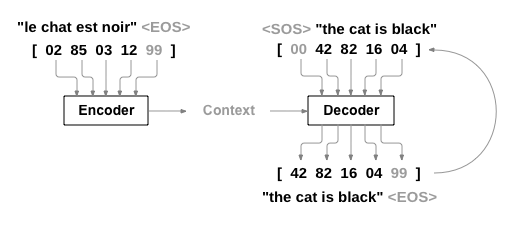

（日本語訳注：上図の例では、[02 85 03 12 99]というシーケンスをEncoderに入力すると、EncoderはContextと記載されている内容を出力します。

続いてDecoderがContextから、[42 82 16 04 99]というシーケンスを出力しています。

また、ここにおける[42 82 16 04 99]といった、シーケンス内の要素番号は、各単語を示します。）

このモデルを改良するために、[アテンション・メカニズム](https://arxiv.org/abs/1409.0473)、を使用します。

アテンション・メカニズムでは、デコーダが注目すべき特定の範囲（=アテンション領域）を学習することを可能にします。

<br>

（日本語訳注：リカレント・ニューラルネットワークをベースとしたsequence to sequenceモデルでは、Decoderは入力シーケンスをまとめてベクトル化した情報を受け取っているため、文における各単語どうしの関係や各単語の重要さが良く分からない、という問題がありました。

これに対し、アテンション・メカニズムを導入することで、どの単語に注目すべきか＝どの単語が重要そうかを学習することが可能となり、より適切な単語関係の理解につながっています。）



**推奨記事**

本チュートリアルでは、PyTorchとPythonがインストール済みであり、また読者がテンソルについて理解していることを前提としています。


-  https://pytorch.org/ PyTorchのインストールガイドです
-  [DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) は、PyTorchを始める方向けの記事です（日本語訳では、「PyTorch入門」で提供）
-  [LEARNING PYTORCH WITH EXAMPLES](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) は、PyTorchをより広く・深く理解する方向けの記事です（日本語訳では、「PyTorch入門」で提供）
-  [PyTorch for Former Torch Users](https://pytorch.org/tutorials/beginner/former_torchies_tutorial.html) は、PyTorchの前身であるLua Torchユーザー向けの記事です






また、Sequence to Sequenceネットワークとその仕組みについても知っておくと良いでしょう

-   [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
-   [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
-   [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
-   [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)

また、これ以前のチュートリアルである 「文字単位RNNによる名前（苗字）の分類]と、「文字単位RNNによる名前（苗字）の生成」は、それぞれ、エンコーダのモデルとデコーダのモデルにそれぞれ非常に似ているので、参考になるでしょう（日本語訳では、「自然言語処理」で提供）。


**設定**

In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

データファイルの読み込み 
=====

本チュートリアルで扱うデータは、英語からフランス語へ翻訳する、数千件のデータペアセットです。



本チュートリアルで使うデータセットが、公開されている[翻訳サイト](https://tataeba.com)は、[Open Data Stack Exchangeのこの質問](https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages)を見て知りました。

このサイトでは、ダウンロード可能な例文は、

https://tatoeba.org/eng/downloads

で公開されています。

そして有難いことに、言語ペアを個々のテキストファイルに分割する作業を以下のサイトで実施してくれている方がいました。

https://www.manythings.org/anki/





英語からフランス語への翻訳ペアは、GitHubリポジトリに含めるにはサイズが大きすぎるので、`data/eng-fra.txt`にダウンロードしてから、このあとの作業を続けてください。

このファイルはタブ区切りの翻訳ペアのリストとなっています

```
I am cold.    J'ai froid.
```

_____
【注】

データを[ここ](https://download.pytorch.org/tutorial/data.zip)からダウンロードして、カレントディレクトリに展開してください。

（日本語訳注：日本語版の本チュートリアルではファイルをダウンロードして使用可能にするセルを、以下に追記しています）
_____

In [8]:
# 日本語訳注：サンプルデータをダウンロードし、zipファイルを解凍するセルを追加
import os
import subprocess
import zipfile

if os.path.exists('./data'):
  print("./data/ already exists")
else:
  subprocess.run("wget https://download.pytorch.org/tutorial/data.zip",shell=True, check=True)
  with zipfile.ZipFile("./data.zip") as zipfile:
    zipfile.extractall(".")

「文字レベルのRNNチュートリアルで使用されている文字エンコーディング」と同様に、本チュートリアルでは各単語をワンホット・ベクトルとして表現します。

ワンホット・ベクトルは、ある単語を示すインデックスのみ1で、それ以外のインデックスは全てゼロの巨大なベクトルです。




「文字」であれば、一つの言語に含まれる数は数十程度でした。

これに対して、「単語」は一つの言語に莫大な数が含まれているため、エンコーディング時に入力するワンホット・ベクトルのサイズが、文字に比べてはるかに大きくなってしまいます。

そこで、本チュートリアルでは、全ての単語を使うのではなく、言語ごとに使う単語数を数千語程度になるようデータをトリミング（切り出し）しましょう。



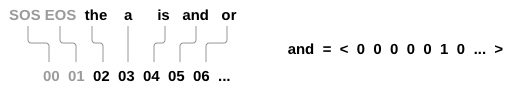

後でネットワークの入力データ及び正解データとして使用するためには、単語ごとに一意のインデックスが必要になります。

単語とインデックスの関係情報を保持するために、`Lang`と名付ける補助クラスを使います。

このクラスは、単語→ インデックス (`word2index`) という辞書と、インデックス → 単語 (`index2word`)という辞書、そして各単語の登場回数の情報`word2count`を保持し、あとで、登場回数が少ない珍しい単語を置換するのにも使用します。

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOSとEOSをカウント

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

ファイルはすべてUnicodeで作成されています。

文をシンプルにするために、文字コードをUnicodeからASCIIに変え、小文字に統一し、ほとんどの句読点を消去します。

In [4]:
# UnicodeをASCIIに変換しています。以下のリンクを参考にしました。
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# 文字を小文字に統一し、文字以外の記号を除外しています
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

データファイルを読み込むには、ファイルを行に分割し、さらに行を[英語 , 他の言語]という形のペアに分割します。

<br>

ファイルは全て英語→他言語なので、他言語→英語に翻訳したい場合を考慮し、ペアを逆にするための`reverse`フラグを用意しています。

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # ファイルを読み込んで行に分割しています
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 全ての行をペアに分割して正規化しています
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # ペアを逆にして、Langインスタンスを作成します
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

非常に多数の例文がありますが、できるだけ短時間でモデルを訓練させたいので比較的短くてシンプルな文だけになるよう、データセットをトリミング（切り出し）します。

<br>

具体的には、以下のようなシーケンスだけが取得されるようにフィルタリングしています。
- 例文の長さが10語以内（語尾の句読点を含む）
- 文の始まりは\"I am\"や\"He is\"などの形（前のステップで、アポストロフィが空白に置き換えられている短縮形のケースも含みます）

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

データ準備で実施する処理内容は、以下の通りです。

-   テキストファイルを読み込んで行に分割、行をさらにペアに分割
-   テキストを正規化し、長さと内容でフィルタリング
-   文章をペアにして単語リストを作る

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['en un sens tu as raison .', 'you are right in a way .']


Seq2Seqモデル 
=============

リカレント・ニューラル・ネットワーク（Recurrent Neural
Network、またはRNN）はシーケンスデータを扱います。

シーケンスにおける、とあるステップの出力を、後続のステップの入力として使用するネットワークです。




そして[Sequence to Sequence network](https://arxiv.org/abs/1409.3215)、`seq2seq
network`、または[Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf)と呼ばれるネットワークは、2つのRNNから構成されるモデルです。

2つのRNNはそれぞれ、エンコーダとデコーダと呼ばれます。

エンコーダは入力シーケンスを読み込んで1つのベクトルを出力し、デコーダはそのベクトルを読み込んで出力シーケンスを生成します。

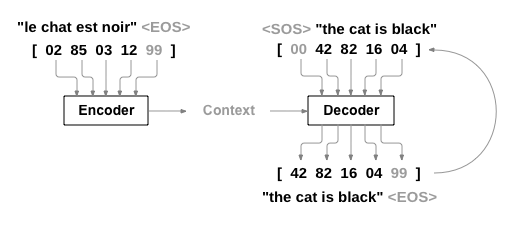

すべての入力が出力に対応する単一のRNNによるシーケンス予測とは異なり、seq2seqモデルでは、シーケンスの長さや順序が自由になるため、2つの言語間の翻訳に適したモデルとなっています。




「Je ne suis pas le chat noir」→「I am not the black cat」という文を考えてみましょう。

入力文のほとんどの単語は出力文では直訳されていますが、\"chat noir\"と\"black cat\"のように少し順番が違います。

また、「ne/pas」構文（日本語訳注：neとpasで否定される単語を挟むという、フランス語の否定文の書き方）のため、フランス語の入力文には、英語よりも単語が1つ増えています。

したがって、入力された単語の並び順に、そのまま直接英語に訳すのは難しいでしょう。




seq2seqモデルでは、エンコーダは1つのベクトルを作成します。

理想的なケースでは、入力シーケンス全体の「意味」がこの1つのベクトル、つまりN次元で表された文章を表現する空間内の1点に、エンコードされます。

エンコーダ（Encoder）
----------

seq2seqネットワークのエンコーダはRNNで、入力文の各単語に対して何らかの値を出力します。

入力シーケンスの各単語に対してエンコーダは、ベクトルと隠れ状態を出力し、隠れ状態は次の単語の生成に使用されます。

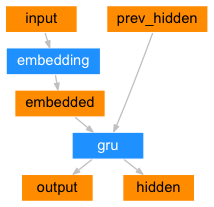

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

デコーダ（Decoder） 
--------

デコーダは、エンコーダとは別のRNNです。デコーダはエンコーダが出力したベクトルを受け取り、翻訳文を生成する単語のシーケンスを出力します。

#### 単純なデコーダー 

最も単純なseq2seqデコーダでは、デコーダはエンコーダの最後の出力ベクトルのみを使用します。

このエンコーダの最後の出力ベクトルは、入力シーケンス全体の文脈をエンコードしていることから、*文脈ベクトル*（context vector）と呼ばれることもあります。

この文脈ベクトルは、デコーダの初期の隠れ状態として使われます。

デコードの各ステップで、デコーダには入力トークンと隠れ状態が与えられます

（日本語訳注：ここでの「ステップ」は1つの単語=トークンの処理を示します）




最初の入力トークンは文字列の先頭を示す`<SOS>トークン`であり、最初の隠れ状態は文脈ベクトル（エンコーダの最後の隠れ状態と同じもの）です。

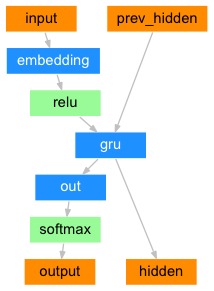

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

このシンプルなモデルを理解するためには、このモデルを訓練させてその結果を確認することをおすすめします。

ですがここでは、紙面の都合上割愛し、本チュートリアルのメインであるアテンション・メカニズムの導入に移ります。

#### アテンションデコーダー（Attention Decoder） 

エンコーダーとデコーダーの間で文脈ベクトルだけが渡される場合、文全体に対するエンコーディング結果が全て文脈ベクトルに集約される形となります。

つまり、一つの文脈ベクトルが、全ての文に対するエンコーディングの結果を担っているのです。



アテンションによって、デコーダは各出力ステップごとに、異なるパターンでエンコーダの出力に対して「フォーカス」することができるようになります。

始めにアテンションの重みを計算します。

これらの重みはエンコーダの出力とかけ算され、重みされた結果になります。

この計算結果（コードでは`attn_applied `）は、入力シーケンスの特定の部分に関する情報を含んでいると考えられ、デコーダが正しい出力単語を選択するのに役立ちます。

<br>

（日本語訳注：例えば、「Je ne suis pas le chat noir」→「I am not the black cat」であれば、"I"の出力時には"Je"に対する重みが大きくなり、"am"の出力時には"suis"に対する重みが大きくなる、というイメージです）


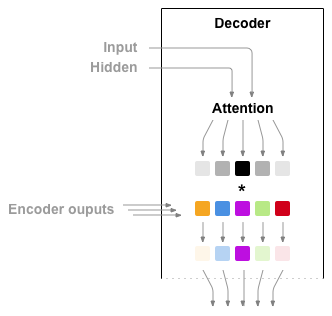

アテンションの重みの計算は、別の全結合層`attn`で行われます。

ここでは、デコーダに対する入力と、隠れ状態を使用して、アテンションの重みの計算をしています。




訓練データには様々な長さの文が含まれているため、全結合層を作成してそれを訓練させるには、このレイヤーが適用できる最大の文の長さ（エンコーダにとっては、入力値の長さ）を選択しなければなりません。

（日本語訳注：全結合層ではベクトルの長を指定する必要があるため、シーケンスの最大長の指定してその長さにそろえる必要があります）



最大の長さの文においては、すべての単語に対応するアンテンションの重みが使用されるでしょうし、短い文では最初の数単語の重みのみが使用されることになります。

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

-----

【注意】

相対的な単語の位置情報を元にしたアプローチを使用することで、シーケンスの長さに制限をかけなくても機能するような、異なるアテンション・メカニズムもあります。

詳細は、[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)における「local attention」の項を参照してください。

-----



訓練 
============

訓練データの作成 
------------------------

モデルを訓練するには、(英語, 他の言語)というペアごとに、入力データのテンソル（入力文に含まれる単語のインデックス）と正解データのテンソル（正解文に含まれる単語のインデックス）が必要となります。

入力データと正解データのテンソルを作成する処理のなかで、EOS（End of Sentence）トークンを入力データ、正解データの各シーケンスに追加する処理も行います。

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

モデルの訓練
--------------------

訓練するには、入力文をエンコーダに投入して実行し、実行の過程のすべての出力と、一番最後の隠れ状態を記録します。


続いて、デコーダには最初の入力として`<SOS> トークン`が渡され、また、エンコーダの最後の隠れ状態が、デコーダの最初の隠れ状態として渡されます。



ここで、\"教師強制\"（Teacher forcing）と呼ばれるアイデアを紹介します。

「教師強制」は、デコーダの推論結果を次のステップのRNNへの入力として使用するのではなく、次のステップでは、実際の正解データをRNNへの入力として使用するという手法です。

教師強制を使用すると、より速く収束しますが、[訓練されたネットワークが悪用されると不安定になり問題になることがあります](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).




教師強制のネットワークの出力は、文法的には正しくても、正しい翻訳からはかけ離れたものになることがあります。

教師強制の直感的な理解としては、以下のようなものとなります。

まず、教師強制は「文法」を表現することを学習させています。

また、正しい翻訳の最初の数語を伝えればそこから意味を「拾う」ことはできます。

しかし、そもそも翻訳で文章を作る方法をきちんと学べてはいません。




PyTorch の `autograd` の自由度のおかげで、単純な if 文だけで、教師強制を使うか使わないかをランダムに選択することができます。

`teacher_forcing_ratio`の値を上げると、より頻繁に教師強制を使うようになります。

In [14]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # 教師強制の場合：次の入力として正解データを渡す。
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
         # 教師強制を使わない：自分の予測を次の入力として使用する
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 入力として使用するために、計算グラフから切り離す

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

以下は、現在の時刻と進行度度合（％表示）が与えられると、経過時間と推定残り時間を表示する補助関数です。

In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

ネットワーク訓練全体のステップは以下の通りです。

-   タイマーを起動
-   オプティマイザーと損失関数を初期化
-   訓練用ペアのセットを作成
-   損失をプロットするために、空の配列を作成

そして、何度も`train`関数を呼び出して、時々進捗状況（データを何%使ったか、これまでの経過時間、推定時間）と損失の平均値を表示します。

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # printする度にリセット
    plot_loss_total = 0  # plot_everyごとにリセット

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

プロット結果 
------------

訓練に保存された損失値の配列 `plot_losses を`用いて，訓練が完了したところまでの損失を、matplotlibでプロットします．

In [17]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')  
# 日本語訳注：Google Colaboratoryでグラフが描画されなくなるため、コメントアウト
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 等間隔でticを設定
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


評価 
====

評価はモデルの訓練とほとんど同じですが、正解データがないので、各ステップごとにデコーダの予測値を自分自身にフィードバックします。

デコーダが単語を予測するたびに、それを出力文字列に追加します。

そして予測結果がEOSトークンとなった場合には、そこで予測を停止します。

さらに、表示用にデコーダのアテンションを保存します。

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

訓練セットからランダムに文章を取り出して評価し、

入力データ、正解データ、予測結果を`print`文で表示することで、

直感的な翻訳の品質判断を行うことができます。

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

訓練と評価 
==================

以上ここまでの補助関数がすべて作成できていれば、実際にネットワークを初期化して訓練を開始することができます（補助関数の作成は余計な手間のように感じるかもしれませんが、訓練を何度も実行することが容易になります）。



本チュートリアルでは入力文を、かなりフィルタリングして制限していたことを覚えていますでしょうか。

フィルタリングした後の小さくなったデータセットに対しては、256個の隠れノードと1つのGRU層から構成される、比較的小さなネットワークで対応できます。

MacBookのCPUを使った場合には、約40分待てば適切な結果が得られるはずです。

（日本語訳注：Google ColaboratoryはGPUモードで実行してください）

_____

【注】

このノートブックを実行している場合は、訓練の最中にカーネルを中断して評価し、その後訓練を再開することができます。

訓練を再開する際には、エンコーダとデコーダが初期化されている行をコメントアウトして、再度`trainIters を`実行してください。

_____

1m 41s (- 23m 43s) (5000 6%) 2.8489
3m 20s (- 21m 42s) (10000 13%) 2.2972
4m 59s (- 19m 57s) (15000 20%) 1.9921
6m 36s (- 18m 10s) (20000 26%) 1.7471
8m 12s (- 16m 25s) (25000 33%) 1.5516
9m 47s (- 14m 40s) (30000 40%) 1.3933
11m 19s (- 12m 56s) (35000 46%) 1.2461
12m 50s (- 11m 14s) (40000 53%) 1.1138
14m 21s (- 9m 34s) (45000 60%) 0.9984
15m 56s (- 7m 58s) (50000 66%) 0.9194
17m 28s (- 6m 21s) (55000 73%) 0.8642
18m 59s (- 4m 44s) (60000 80%) 0.7472
20m 31s (- 3m 9s) (65000 86%) 0.6851
22m 3s (- 1m 34s) (70000 93%) 0.6361
23m 35s (- 0m 0s) (75000 100%) 0.6011


<Figure size 432x288 with 0 Axes>

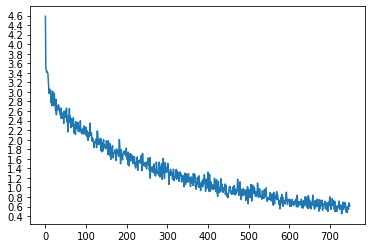

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

# 日本語訳注：GoogleColabのGPU環境で25分ほどかかります。

In [21]:
evaluateRandomly(encoder1, attn_decoder1)

> vous etes une de ces dragueuses !
= you re such a flirt .
< you are such a flirt . <EOS>

> je suis ton ami .
= i m your friend .
< i m your friend . <EOS>

> je vais etre papa .
= i m going to be a father .
< i m going to be a father . <EOS>

> nous sommes fauchees .
= we re broke .
< we re broke . <EOS>

> il est le president du comite .
= he s the chairman of the committee .
< he s the the the the committee . <EOS>

> tu es trop naive .
= you re too naive .
< you re too naive . <EOS>

> je suis claustrophobe .
= i m claustrophobic .
< i m claustrophobic . <EOS>

> vous etes idiotes .
= you re silly .
< you re safe . <EOS>

> je suis un peu ivre .
= i m a bit drunk .
< i am a bit drunk . <EOS>

> il l a fait auparavant .
= he s done it before .
< he s done it before . <EOS>



アテンション（Attention）を可視化する 
------------------

アテンション・メカニズムの便利な特性は、出力結果の解釈可能性がとても高いことです。

アテンションは、特定の入力シーケンスに対応するエンコーダ出力に重み付けをするために使用されています。

したがって、アテンションを使うことで各タイムステップごと（=トークンごと）に、ネットワークが最も注目している箇所を探せそうだ、と容易に想像がつきます。


単純に`plt.matshow(attentions) `を実行すると、アテンションの出力が行列として表示されます。

列が入力ステップ、行が出力ステップとなります。

（日本語訳注：ここでいう「ステップ」は、本チュートリアルでは「単語」に相当します。したがって、列の番号は、入力されたシーケンスの単語インデックスを示しています）

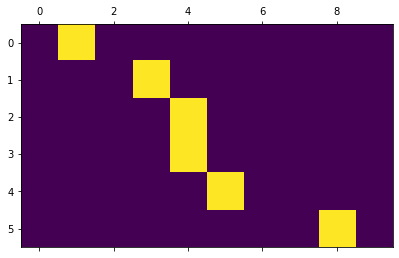

In [22]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())


より見やすく、分かりやすくするために、軸とラベルの追加作業を行います。

input = elle a cinq ans de moins que moi .
output = she s been years older than i am . <EOS>


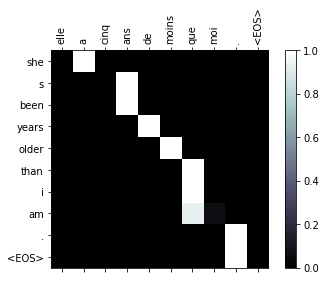

input = elle est trop petit .
output = she s too fat . <EOS>


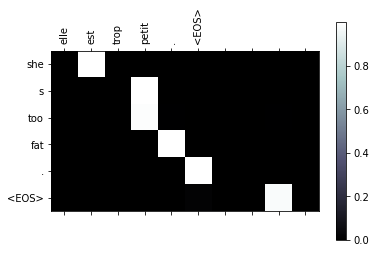

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


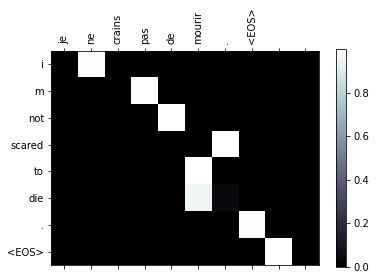

input = c est un jeune directeur plein de talent .
output = he s a talented young . . <EOS>


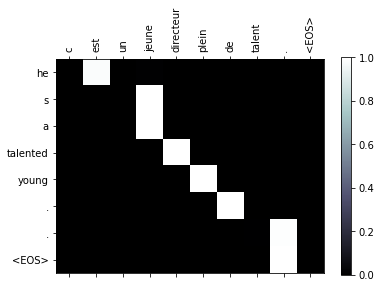

In [23]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

演習 
====

-   異なるデータセットで試してみましょう

    -   別の言語ペア
    -   人間→機械（例えば、IoTコマンドなど）
    -   チャット→レスポンス
    -   質問→回答

-   単語トークンの表現を、word2vecやGloVeのような訓練済みの単語埋め込みに置き換えてみましょう

-   より多くのレイヤー、より多くの隠れたユニット、より多くの文で試してみましょう。そして、訓練時間と結果を比較してみましょう。

-   ペアが、2つの同じ組み合わせとなっている翻訳ファイル（`I am test \t I am test`）を使えば、このネットワークをオートエンコーダーとして使うことができます。これを試してみてください。

    -   オートエンコーダーとしての訓練
    -   エンコーダネットワークのみ保存
    -   その状態から翻訳のための新しいデコーダーを訓練